Re-implement [this](https://github.com/Rachnog/Neural-Networks-for-Differential-Equations/blob/master/ODE%20example.ipynb) by TensorFlow.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

Solve the ODE:
$$\frac{d y}{d x} (x) = f \left( x, y(x) \right),$$
in range $x \in [0, 1]$, with initial condition:
$$y(0) = 1.$$

XXX:
$$y(x) = 1 + x h(x).$$
where $h$ for neural network.

Define $f$:

In [2]:
# Auxillary functions
def A(x):
    return x + (1 + 3 * x**2) / (1 + x + x**3)

def B(x):
    return x**3 + 2 * x + x**2 * ((1 + 3 * x**2) / (1 + x + x**3))

def f(x, y):
    """$(dy/dx)(x) = f(x, y(x)).$"""
    return B(x) - y * A(x)

We have had the analytic solution of the ODE, as

In [3]:
def analytic_solution(x):
    """For comparison."""
    return np.exp((-x**2)/2) / (1 + x + x**3) + x**2

In [4]:
dx = 1 / 100
x_space = np.linspace(0, 1, int(1/dx))    
y_analytic = analytic_solution(x_space)

For comparsion, make numerical solution to the ODE via Euler's method, as

In [5]:
%%time

y_numerical = np.zeros_like(y_analytic)
y_numerical[0] = 1  # initiail condition.

# Numerical solution
for i, x in enumerate(x_space[1:], 1):
    y_numerical[i] = ( y_numerical[i-1]
                      + B(x) * dx
                      - y_numerical[i-1] * A(x) * dx )

Wall time: 0 ns


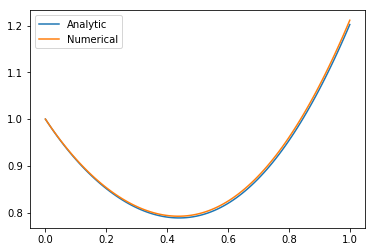

In [6]:
plt.figure()
plt.plot(x_space, y_analytic, label='Analytic')
plt.plot(x_space, y_numerical, label='Numerical')
plt.legend()
plt.show()

In the following, we solve this ODE by neural network.

In [7]:
def make_f(x, y, name=None):
  """Re-implement $f$ in TensorFlow.
  Args:
    x: Tensor-like.
    y: Tensor-lile.
  Returns:
    Tensor, as the $f(x, y)$.
  """
  x = tf.convert_to_tensor(x, name='x')
  y = tf.convert_to_tensor(y, name='y')

  with tf.name_scope(name, 'f', [x, y]):
    #f = B(x) - y * A(x)
    f = tf.sin(x) / (1.1 - x)
    
  return f

def make_boundary_condition(x, y, name=None):
  """Implements the boundary condition $b(x, y)$ for which
  $b(x, y) = 0$. In our specific example, $b(x, y) := y_0 - 1$.
  Args:
    x: Tensor-like.
    y: Tensor-like.
  Returns:
    Tensor, as the boundary condition $b(x, y)$.
  """
  x = tf.convert_to_tensor(x, name='x')
  y = tf.convert_to_tensor(y, name='y')
    
  with tf.name_scope(name, 'BoundaryCondition', [x, y]):
    y_list = tf.unstack(y)
    boundary_condition = y_list[0] - 1
    
  return boundary_condition

In [8]:
def make_neural_network(x, units_list, activation=tf.nn.sigmoid, name=None):
  """Implement the neural network with dense hidden layers, each with
  the same activation-function `activation`, and regularized by a
  dropout layer with dropout-rate as the default (i.e. 0.5).
  Args:
    x: Tensor-like, as the input of the neural network.
    units_list: List of integers, as the number of units of the
        hidden layers.
    activation: Callable, as the activation-function of the hidden-
        layers. Defaults to `tf.nn.sigmoid`.
  Returns:
    The output tensor of the neural network.
  """
  x = tf.convert_to_tensor(x, name='x')

  with tf.name_scope(name, 'NeuralNetwork', [x]):
    
    # On the shape of `x`
    if not x.shape:
      raise ValueError('`x` shall have batch-dimension.')
    elif len(x.shape) == 1:
      # `x`'s shape `[batch_size]` => `[batch_size, 1]`
      x = tf.expand_dims(x, axis=1)
    else:
      # Regard the `x`'s shape as `[batch_size] + event_shape`
      pass
    
    # Hidden layers
    hidden = x  # initialize.
    for units in units_list:
      hidden = tf.layers.dense(hidden, units, activation=activation)
      hidden = tf.layers.dropout(hidden)
    
    # Output layer, demanding the output shape `[batch_size]`
    # shape: `[batch_size, 1]`
    output = tf.layers.dense(hidden, 1)
    # `output`'s shape `[batch_size, 1]` => `[batch_size]`
    output = tf.squeeze(output, axis=1)

  return output

Loss is defined by:
$$\mathcal{L} := \frac{1}{N_x} \sum_{x_i} d\left( \frac{dy}{dx}(x_i), f(x_i, y(x_i)) \right) + \frac{1}{N_b} \sum_{x_b} d\left( b(x_b, y_b), 0 \right),$$
for some distance $d(x, y)$.

In [9]:
def make_distance(x, y, name=None):
  """Mean square distance between tensors `x` and `y`."""
  with tf.name_scope(name, 'MeanSquareDistance', [x, y]):
    distance = tf.reduce_mean(tf.square(x - y))
  return distance

def make_loss(x, units_list, name=None):
  """Implements the loss.
  Args:
    x: Tensor-like, as the input of the neural network.
  Returns:
    Scalar, as the loss.
  """
  with tf.name_scope(name, 'Loss', [x]):
    x = tf.convert_to_tensor(x, name='x')
    y_neural_network = make_neural_network(x, units_list)
    y = 1 + x * y_neural_network
    f = make_f(x, y)
    grad_y = tf.gradients(y, [x])[0]
    loss = make_distance(grad_y, f)
    return loss, y

In [10]:
%%time
tf.reset_default_graph()

units_list = [10, 10, 10]
loss, y_neural_network, *rests = make_loss(x_space, units_list)

# For optimizing
optimizer = tf.train.AdamOptimizer(0.01)
train_op = optimizer.minimize(loss)

# For logging
tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge_all()

sess = tf.Session()

Wall time: 359 ms


In [11]:
%%time
# -- Initializing
# For logging
writer = tf.summary.FileWriter('./logdir', sess.graph)
# Initialize all `tf.Variable`s, explicit or implicit
sess.run(tf.global_variables_initializer())

# -- Optimizing

# Parameters
n_iters = 10**5
tolerance = 1e-6

# Iterations
for i in range(n_iters):
    _, summary_value, loss_value = sess.run([train_op, summary_op, loss])

    step = i + 1
    writer.add_summary(summary_value, step)

    if abs(loss_value) < tolerance:
        break

    if step % 100 == 0:
        print(step, loss_value)

# Return the predict-values of the trained neural network
y_neural_network_value = sess.run(y_neural_network)

100 2.454009002812669
200 0.06347927139301653
300 0.03825671558305885
400 0.027364837020553888
500 0.014096369200015824
600 0.004854863340611517
700 0.002771165683603907
800 0.002206859012450416
900 0.001680655066903235
1000 0.0013902248139749812
1100 0.0011373637982917196
1200 0.0009222931051060531
1300 0.0007466835099660298
1400 0.0005975304684317544
1500 0.0004750781554997114
1600 0.0003918251782211282
1700 0.0003261824145536783
1800 0.00028287860497532946
1900 0.0029571342318793557
2000 0.00023073804909147237
2100 0.00021309272334069727
2200 0.00019818252981291826
2300 0.0002251623764662096
2400 0.00017476771272630326
2500 0.00016549593433940206
2600 0.0003201365636569199
2700 0.0001502277824357697
2800 0.000144083793246921
2900 0.00013856705324557863
3000 0.00013754777080503226
3100 0.0001291209437384637
3200 0.0001250974068465494
3300 0.0002122100949908426
3400 0.00011769781636226748
3500 0.00011446194932079969
3600 0.0037787776351459012
3700 0.0001080858950516353
3800 0.00010521

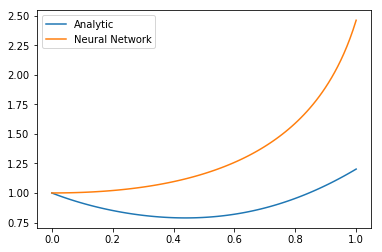

In [12]:
plt.figure()
plt.plot(x_space, y_analytic, label='Analytic')
#plt.plot(x_space, y_numerical, label='Numerical')
plt.plot(x_space, y_neural_network_value, label='Neural Network')
plt.legend()
plt.show()